In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import configparser
import os.path
from os import path
from importlib import reload
import wandb


creds_path_ar = ["../../credentials.ini","credentials.colab.ini"]
PATH_ROOT = ""
PATH_DATA = ""

for creds_path in creds_path_ar:
    if path.exists(creds_path):
        config_parser = configparser.ConfigParser()
        config_parser.read(creds_path)
        PATH_ROOT = config_parser['MAIN']["PATH_ROOT"]
        PATH_DATA = config_parser['MAIN']["PATH_DATA"]
        WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
        ENV = config_parser['MAIN']["ENV"]
        break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)

In [5]:
cd {PATH_ROOT}

/home/shaul/workspace/GitHub/sota-mafat-radar


In [ ]:
pip install numpy==1.18.5

In [6]:
import os
import pandas as pd
import numpy as np
from termcolor import colored
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [7]:
from src.data import get_data, feat_data
from src.visualization import *
from src.features import add_data, augmentations, specto_feat
from src.models import *

In [8]:
train_path = 'MAFAT RADAR Challenge - Training Set V1'
data = get_data.load_data(train_path, folder=PATH_DATA)

In [9]:
data.keys()

dict_keys(['segment_id', 'track_id', 'geolocation_type', 'geolocation_id', 'sensor_id', 'snr_type', 'date_index', 'target_type', 'doppler_burst', 'iq_sweep_burst'])

In [10]:
segment_id = 0
track_id = data['track_id'][segment_id]
iq = data['iq_sweep_burst'][segment_id]
track, _ = add_data.concatenate_track(data, track_id)
doppler = data['doppler_burst'][segment_id]
label = data['target_type'][segment_id]
angle = 10

## Homegrown Augmentations

In [11]:
new_segments = augmentations.split_rotation(data, track_id, angle=angle, n_splits=4)

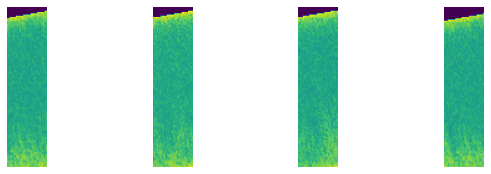

In [12]:
plt.figure(figsize=(10, 10))
for i, augmented_image in enumerate(new_segments.values()):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

In [13]:
augmented_image.shape

(128, 32)

## Keras Augmentation

In [14]:
image = specto_feat.calculate_spectrogram(iq)
image = tf.expand_dims(image, -1)

In [15]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
#   layers.experimental.preprocessing.Rescaling(1./255)
])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



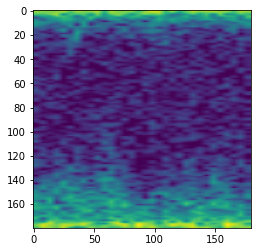

In [16]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [17]:
image = tf.expand_dims(result, 0)

In [18]:
data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

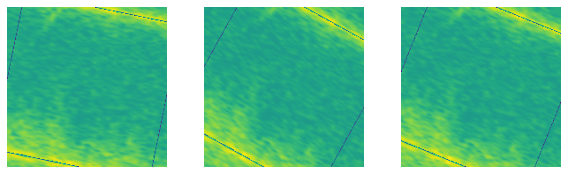

In [19]:
plt.figure(figsize=(10, 10))
for i in range(3):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")